We start by importing the Breast Cancer Dataset.

In [23]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()

X, y = data.data, data.target

We perform data standardization over the dataset.

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [25]:
scaled_data = scaler.fit(X).transform(X)

We apply Principal Component Analysis (PCA) with the 2 parameters with higher variance, removing redundant features and reducing the negative effects of noise by making the data more compact.

It also makes the data easier to visualize.

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')

X_pca = pca.fit(scaled_data).transform(scaled_data)

We can now visualize the data to gain a better understanding of it.

<Axes: >

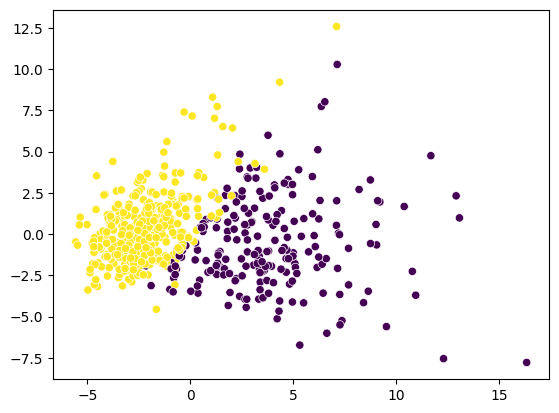

In [27]:
import seaborn as sns

sns.scatterplot(x= X_pca[:,0], y= X_pca[:,1], c=y)

There can be observed some separation between classes, although some points overlap in the bordering area.

We follow by aplying EM clustering over the training data.

In [28]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=0.7, random_state=42)

em = GaussianMixture(n_components=2, covariance_type='full', max_iter=100, random_state=42)
em_model = em.fit(X_train)

We get the centers of the Radial Basis Functions of the hidden layer.

In [32]:
import numpy as np

centers = em_model.means_
cov = em_model.covariances_

spread = [np.linalg.det(em_model.covariances_[0]), np.linalg.det(em_model.covariances_[1])]

print("Centers: " + str(centers))
print("Spreads " + str(spread))

Centers: [[ 3.16585515  0.21989671]
 [-2.41749718 -0.25693232]]
Spreads [np.float64(101.42858288708811), np.float64(3.4840632315574633)]


Performing a data split

In [1180]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=0.7, random_state=42)

RADIAL BASIS FUNCTION NEURAL NETWORK

We define the function hidden_layer that builds the matrix enclosing the values of the two RBFs applied to each point of the training data.

In [1181]:
def gaussian(x, c, s):
    return np.exp(-((np.linalg.norm(c-x))**2)/(2*(s**2)))

def hidden_layer(X, c, s):
    matrix = []
    
    for x in X:
        row = []
        for i in range(2):
            row += [gaussian(x, c[i], s[i])]
        matrix += [row]
    return np.array(matrix)

With the hidden layer matrix we can now calculate the weights with the pseudoinverse problem.

In [1182]:
def weights(matrix, y):
    return np.matmul(np.linalg.pinv(matrix), y)

We predict test instances by forwarding them into the network i.e. building a matrix with their values after applying each RBF and multiplying it by the weights. 
A threshold of 0.5 determines the classes.

In [1184]:
def predict(x, c, s, w):
    
    hidden = hidden_layer(x, c, s)
    out = np.matmul(hidden, w)
    
    return out

def threshold(pred):
    for i in range(len(pred)):
        if pred[i] > 0.5:
            pred[i] = 1
        else:
            pred[i] = 0
    return pred

Backpropagation functions to fine-tune weights and centers.

In [1186]:
def backpropagation_weights(hidden, out, y, weights, rate):
    batch_update = np.array([0, 0])
    for i in range(len(y)-1):
        batch_update = np.add(batch_update, (hidden[i] * (y[i] - out[i])))
    return np.add(weights, rate*batch_update)

In [1187]:
def backpropagation_centers(x, hidden, out, y, weights, c, s, rate):
    batch_update = np.array([0, 0])
    for i in range(len(y)-1):
        D = np.divide(np.subtract(x[i], c), [s[0]**2, s[1]**2])
        batch_update = np.add(batch_update, (y[i]-out[i]) * np.transpose(weights) @ (hidden[i] @ D))
    return np.add(c, rate*batch_update)

In [1189]:
def backpropagation_algo(train, centers, spread, weights, y):
    
    new_w, new_c, new_s = weights, centers, spread

    for epoch in range(100):
        hidden = hidden_layer(train, centers, spread)
        out = predict(train, new_c, new_s, new_w)
        new_w = backpropagation_weights(hidden, out, y, new_w, rate=0.002)

    for epoch in range(300):
        hidden = hidden_layer(train, centers, spread)
        out = predict(train, new_c, new_s, new_w)
        new_c = backpropagation_centers(train, hidden, out, y, new_w, new_c, new_s, rate=0.0001)
        
    return [new_w, new_c, new_s]

Code demonstration:

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

# Define a 70/30 cross-validator
splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

accuracies_test_bp = []
accuracies_test_nobp = []

# Cross validation
for train_index, test_index in splitter.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Data stadardization/PCA
    scaled_train = scaler.fit(X_train).transform(X_train)
    X_train = pca.fit(scaled_train).transform(scaled_train)

    #EM clustering over the training set
    em = GaussianMixture(n_components=2)
    em_model = em.fit(X_train)

    # Get centers and spread
    centers = em_model.means_
    spread = [np.linalg.det(em_model.covariances_[0]), np.linalg.det(em_model.covariances_[1])]

    # Build hidden layer matrix
    hidden = hidden_layer(X_train, centers, spread)

    # Compute the weights
    w = weights(hidden, y_train)

    # Fine tune the parameters using backpropagation
    new_params = backpropagation_algo(X_train, centers, spread, w, y_train)
        
    # PREDICTION 
    scaled_test = scaler.fit(X_test).transform(X_test)
    X_test = pca.fit(scaled_test).transform(scaled_test)
    
    pred_test_nobp = threshold(predict(X_test, centers, spread, w)) # without backpropagation
    accuracies_test_nobp.append(accuracy_score(y_test, pred_test_nobp))

    pred_test_bp = threshold(predict(X_test, new_params[1], spread, new_params[0])) # with backpropagation
    accuracies_test_bp.append(accuracy_score(y_test, pred_test_bp))


print("Cross-validated accuracies test bp:", accuracies_test_bp)

print("Cross-validated accuracies test no bp:", accuracies_test_nobp)

print("Mean accuracy bp:", np.mean(accuracies_test_bp))

print("Mean accuracy no bp:", np.mean(accuracies_test_nobp))

Cross-validated accuracies test bp: [0.8771929824561403, 0.8713450292397661, 0.8713450292397661, 0.8830409356725146, 0.8888888888888888]
Cross-validated accuracies test no bp: [0.8596491228070176, 0.8421052631578947, 0.8771929824561403, 0.8830409356725146, 0.8830409356725146]
Mean accuracy bp: 0.8783625730994153
Mean accuracy no bp: 0.8690058479532163
